In [41]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

<font size="5">**Punto 1**.</font>

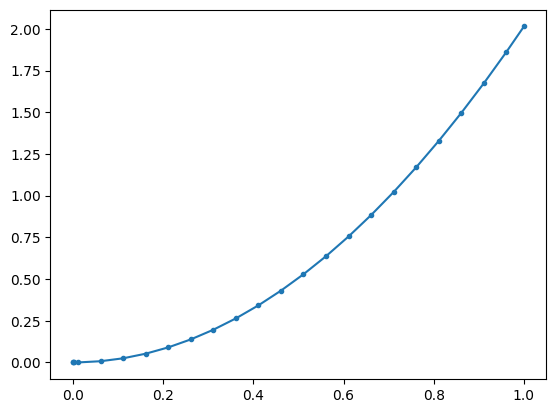

[[ 0.00000000e+00  1.75605230e-08  2.12482327e-06  2.16363024e-04
   6.55554660e-03  2.16735142e-02  4.55672017e-02  7.82317680e-02
   1.19660600e-01  1.69845316e-01  2.28775775e-01  2.96440084e-01
   3.72824606e-01  4.57913972e-01  5.51691095e-01  6.54137181e-01
   7.65231745e-01  8.84952629e-01  1.01327602e+00  1.15017645e+00
   1.29562686e+00  1.44959858e+00  1.61206136e+00  1.74430986e+00]
 [-0.00000000e+00 -1.01385727e-08 -1.22676729e-06 -1.24917250e-04
  -3.78484660e-03 -1.25132093e-02 -2.63082362e-02 -4.51671323e-02
  -6.90860795e-02 -9.80602389e-02 -1.32083755e-01 -1.71149762e-01
  -2.15250386e-01 -2.64376755e-01 -3.18519002e-01 -3.77666277e-01
  -4.41806754e-01 -5.10927638e-01 -5.85015180e-01 -6.64054683e-01
  -7.48030517e-01 -8.36926129e-01 -9.30724057e-01 -1.00707777e+00]]


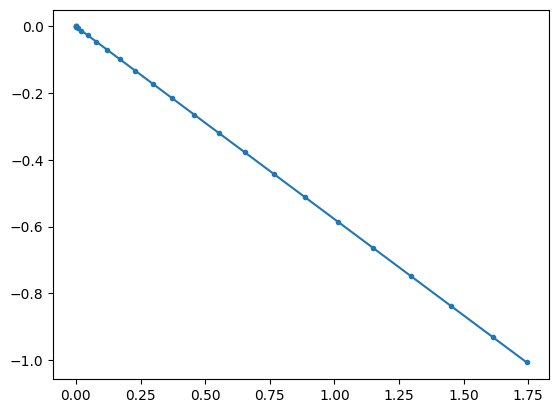

In [72]:
sin = np.sin
cos = np.cos

def system(t,y, theta, gamma, mass):
    x,v = y
    return [v, 9.81*sin(theta)-gamma*9.81*cos(theta) - (gamma/mass)*v**2] #Primero se pone la ecuacion dif. correspondiente a x [dx/dt = v], luego la de v [a=dv/dt=....]

theta = np.deg2rad(30)
y0 = np.array([0.,0.])
t_span = (0,1) #tiempos desde 0 a 1
args = [theta, 0.1, 10] #ángulo theta, coeficiente gamma y la masa
sol = solve_ivp(
    system, 
    y0=y0, 
    t_span=t_span, 
    args=args, 
    max_step=0.05
    )

#sol.t es el linspace de tiempos que genera solve_ivp
#sol.y es un array [x,v] primero pone el array de puntos que solucionan dx/dt=v, luego el array de puntos que solucionan dv/dt=....
plt.plot(sol.t, sol.y[0],".-")
plt.show()

coord = np.array([cos(-theta)*sol.y[0],sin(-theta)*sol.y[0]]) #No le encuentro sentido al -theta y que la gráfica esté bien
print(coord)

plt.plot(coord[0], coord[1],".-")
plt.show()